#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [175]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
import logging
from keras.regularizers import l2

# 6 iterations:
1. -> 1 lstm layers gridsearch  
2. -> 2 lstm layer gridsearch  
3. -> 1 lstm layer med l1 eller l2 gridsearch  
4. -> 1 lstm layer for kun makro gridsearch  
5. -> 1 lstm layer for kun technical gridsearch  
6. -> 1 lstm layer med inflation og unemployment + tekniske (Momentum, RSI, MACD, MA) gridsearch


## Configuration of logging:

In [176]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

## Setting Device to GPU

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [335]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

# Data Loading

In [532]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,:1]

In [535]:
num_zeros = np.sum(diff == 0)
print(num_zeros)


42


In [442]:
np.random.seed(42)
tf.random.set_seed(42)

# Output Variable Transformation and Data Scaling

In [443]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
#25th: -0.0037000000000000366
#75th: 0.003649999999999931
#40th: -0.0012000000000000899
#60th: 0.0013000000000000789
#33th: -0.0023999999999999
#66th: 0.0021999999999999

def categorize_diff(diff):
    if diff < -0.0023999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])


# Conversion to Tensor

In [211]:
def create_dataset(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

# 1st Model

* time steps = 10,
* epochs = 100,
* 1 hidden layer,
* 0.3 dropout rate,
* 32 batch size,

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model(units1=128, dropout_rate1 = 0.3, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [ ]:
param_grid = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__units1': 128}


In [ ]:
best_model = create_model(batch_size = best_params['batch_size'],
                          dropout_rate1 = best_params['model__dropout_rate1'],
                          units1 = best_params['model__units1']
                          )

In [ ]:
history = best_model.fit(X_train, y_train,
                         epochs = 75,
                         batch_size = best_params['batch_size'],
                         validation_data = (X_test, y_test),
                         shuffle = False,
                         verbose=0
                         )

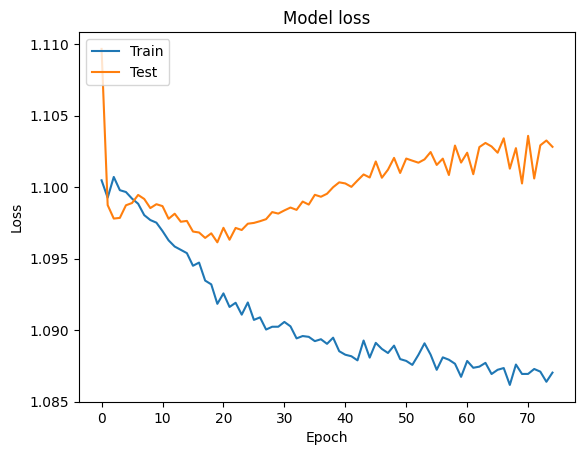

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

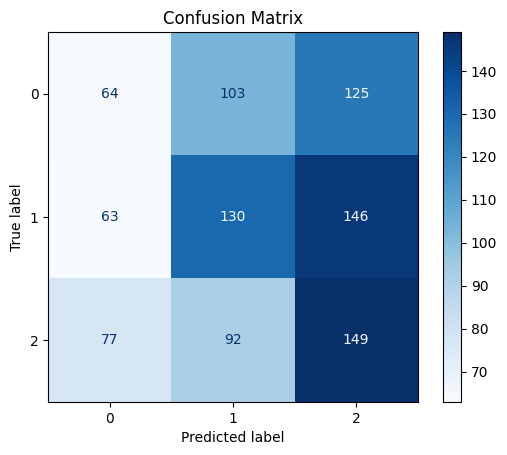

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [ ]:
model_save_path = 'first_iteration_lstm.keras'
best_model.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


In [ ]:
loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                       │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

# 2nd Iteration

2 lstm layer gridsearch

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model_2(units1=128, units2 = 64, dropout_rate1 = 0.3, dropout_rate2 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_2 = KerasClassifier(model=create_model_2, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [ ]:
param_grid_model2 = {
    'model__units1': [32, 64, 128],
    'model__units2': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'model__dropout_rate2': [0.3, 0.2, 0.1],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=param_grid_model2, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_2 = grid_model_2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params_model_2 = grid_result_model_2.best_params_
logging.info(f"Best Parameters: {best_params_model_2}")
print(best_params_model_2)

{'batch_size': 32, 'model__dropout_rate1': 0.2, 'model__dropout_rate2': 0.1, 'model__units1': 128, 'model__units2': 128}


In [ ]:
best_model_2 = create_model_2(units1=best_params_model_2['model__units1'],
                            units2 = best_params_model_2['model__units2'],
                          dropout_rate1 = best_params_model_2['model__dropout_rate1'],
                            dropout_rate2 = best_params_model_2['model__dropout_rate2'],
                          batch_size = best_params_model_2['batch_size']
                          )

In [ ]:
history_model_2 = best_model_2.fit(X_train, y_train,
                         epochs=75,
                         validation_data=(X_test, y_test),
                         verbose=0)

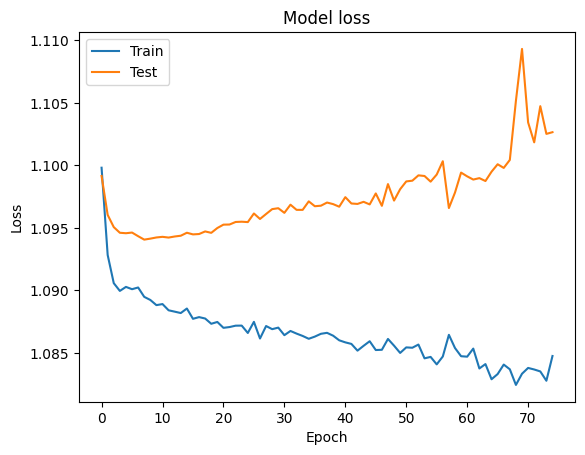

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Figure size 1000x700 with 0 Axes>

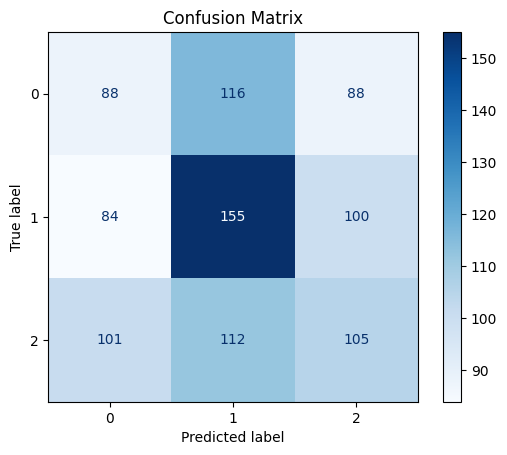

In [ ]:
y_pred = best_model_2.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 128)             │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,531 (2.42 MB)

 Trainable params: 211,843 (827.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,688 (1.62 MB)

In [ ]:
model_2_save_path = 'second_iteration_lstm.keras'
best_model_2.save(model_2_save_path)
logging.info(f"Model saved to {model_2_save_path}")


# 3rd Iteration

1 lstm layer med l1 eller l2 gridsearch  


In [ ]:
from tensorflow.keras.regularizers import l1_l2

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_model_3(units1=128, dropout_rate1 = 0.3, batch_size = 32, l1 = 0.01, l2 = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l1_l2(l1=l1, l2=l2))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_3 = KerasClassifier(model=create_model_3, epochs = 100, verbose=0, random_state = 42)

In [ ]:
param_grid_model3 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l1': [0.01, 0.001],
    'model__l2': [0.01, 0.001]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_model3, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__l1': 0.01, 'model__l2': 0.01, 'model__units1': 128}


In [ ]:
best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l1 = best_params_model_3['model__l1'],
                          l2 = best_params_model_3['model__l2']
                          )

In [ ]:
history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                         verbose=0)

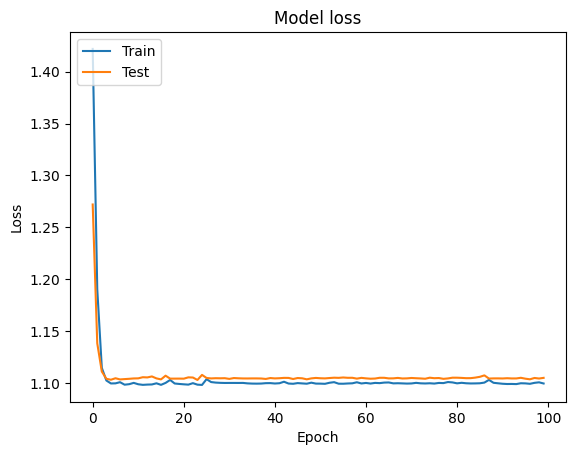

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

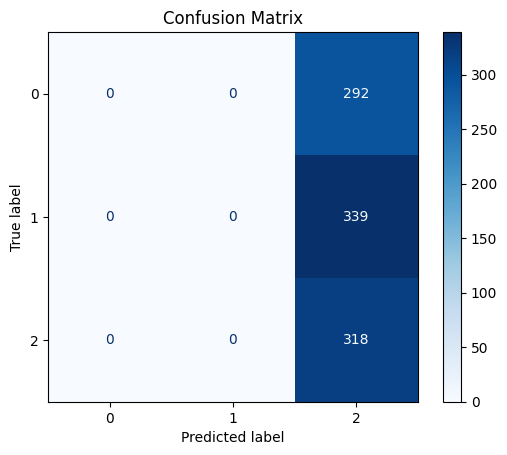

In [ ]:
y_pred = best_model_3.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [ ]:
model_3_save_path = 'third_iteration_lstm.keras'
best_model_3.save(model_3_save_path)
logging.info(f"Model saved to {model_3_save_path}")


# 4th Iteration

SLSTM with only technical variables


In [69]:
logging.info('Loading dataset...')

file_path = '/content/technical_indicators_stationary.csv'
df = pd.read_csv(file_path)
df = df.drop(columns = ['date'])
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,1:2]

In [49]:
print(diff)

[[-0.0003]
 [-0.0105]
 [-0.0125]
 ...
 [ 0.0079]
 [-0.0041]
 [-0.0011]]


In [73]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [74]:
def create_model_4(units1 = 128, dropout_rate1 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation = 'softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
param_grid_model_4 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128]
}

In [76]:
model_4 = KerasClassifier(model=create_model_4, epochs = 75, verbose=0, random_state = 42)

In [77]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_4 = GridSearchCV(estimator=model_4, param_grid=param_grid_model_4, cv=5, scoring = 'accuracy', n_jobs = -1)

In [78]:
# Fit the grid search
grid_result_model_4 = grid_model_4.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [58]:
best_params_model_4 = grid_result_model_4.best_params_
logging.info(f"Best Parameters: {best_params_model_4}")
print(best_params_model_4)

{'batch_size': 64, 'model__dropout_rate1': 0.3, 'model__units1': 32}


In [59]:
best_model_4 = create_model_4(units1 = best_params_model_4['model__units1'],
                          dropout_rate1 = best_params_model_4['model__dropout_rate1'],
                          batch_size = best_params_model_4['batch_size']
                          )

In [66]:
history_model_4 = best_model_4.fit(X_train, y_train,
                         epochs=30,
                         validation_data=(X_test, y_test),
                         verbose=0)

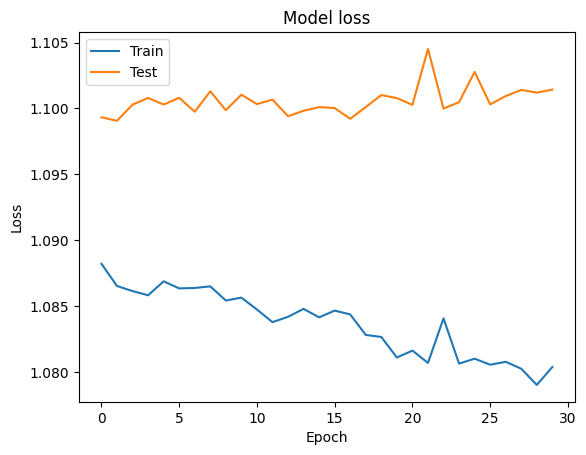

In [67]:
# Plot training & validation loss values
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

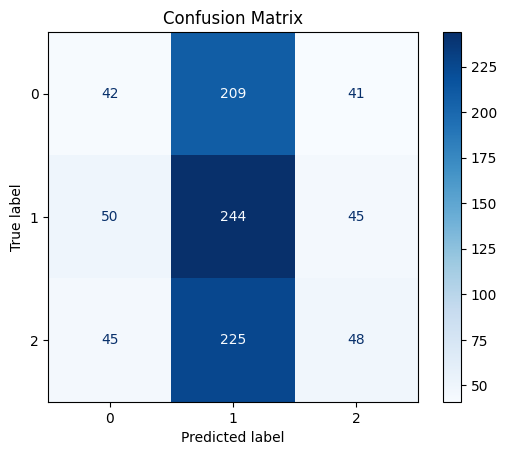

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model_4.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [64]:
best_model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,195 (67.17 KB)

 Trainable params: 5,731 (22.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,464 (44.79 KB)

In [65]:
model_4_save_path = 'fourth_iteration_lstm.keras'
best_model_4.save(model_4_save_path)
logging.info(f"Model saved to {model_4_save_path}")

# 5th Model (Not run yet)

In [524]:
logging.info('Loading dataset...')

file_path = '/content/usd_eur_raw.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['date'])
dataset = df.values.astype('float64')

In [525]:
# Extract the target variable (e.g., the second column which is the raw usd/eur exchange rate)
target = dataset[:, 1]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the entire dataset including the input and target
scaled_dataset = scaler.fit_transform(dataset)


In [526]:
time_steps = 15

def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :-1])  # Use all columns except the last one for input
        y.append(data[i + time_steps, -1])       # Use the last column for target
    return np.array(X), np.array(y)

# Create the lagged dataset
X, y = create_dataset(scaled_dataset, time_steps)

# Reshape X for LSTM input
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to 3D array for LSTM: [samples, time steps, features]

# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [527]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, Input
from tensorflow.keras.losses import Huber

def create_model_5(units1=128, dropout_rate1=0.3, batch_size=32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae'])
    return model

In [484]:
from scikeras.wrappers import KerasRegressor

model_5 = KerasRegressor(build_fn=create_model_5, epochs = 75, verbose=0, random_state = 42)

In [485]:
param_grid_model_5 = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [486]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_5 = GridSearchCV(estimator=model_5, param_grid=param_grid_model_5, cv=5, n_jobs = -1)

In [488]:
# Fit the grid search
grid_result_model_5 = grid_model_5.fit(X_train, y_train)

KeyboardInterrupt: 

In [322]:
best_params_model_5 = grid_result_model_5.best_params_
logging.info(f"Best Parameters: {best_params_model_5}")
print(best_params_model_5)

{'batch_size': 128, 'model__dropout_rate1': 0.2, 'model__units1': 32}


In [528]:
best_model_5 = create_model_5(batch_size = best_params_model_5['batch_size'],
                          dropout_rate1 = best_params_model_5['model__dropout_rate1'],
                          units1 = best_params_model_5['model__units1'],
                          )

In [529]:
history_model_5 = best_model_5.fit(X_train, y_train,
                         epochs = 200,
                         validation_data = (X_test, y_test),
                         verbose=1,
                          shuffle = False
                         )

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0270 - mae: 0.1238 - val_loss: 0.0619 - val_mae: 0.2275
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mae: 0.1234 - val_loss: 0.0561 - val_mae: 0.2169
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - mae: 0.1114 - val_loss: 0.0456 - val_mae: 0.1929
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - mae: 0.1020 - val_loss: 0.0339 - val_mae: 0.1612
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - mae: 0.0923 - val_loss: 0.0235 - val_mae: 0.1275
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - mae: 0.0837 - val_loss: 0.0160 - val_mae: 0.1004
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - mae: 0.0772 - val_loss: 0.0114 - val_mae: 0.0829
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - mae: 0.0703 - val_loss: 0.0086 - val_mae: 0.0720
Epoch 9/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

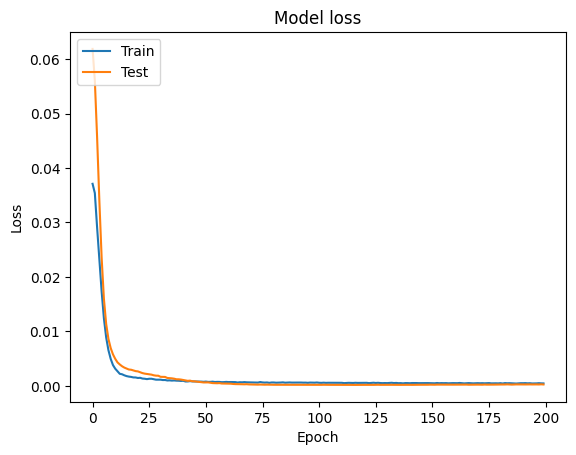

In [530]:
# Plot training & validation loss values
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error (MSE): 0.00024104626232107396
Mean Absolute Error (MAE): 0.007965821631733124
R^2 Score: 0.9760116227971773
Out-of-Sample (OOS) R^2 Score: -1762.501763496988


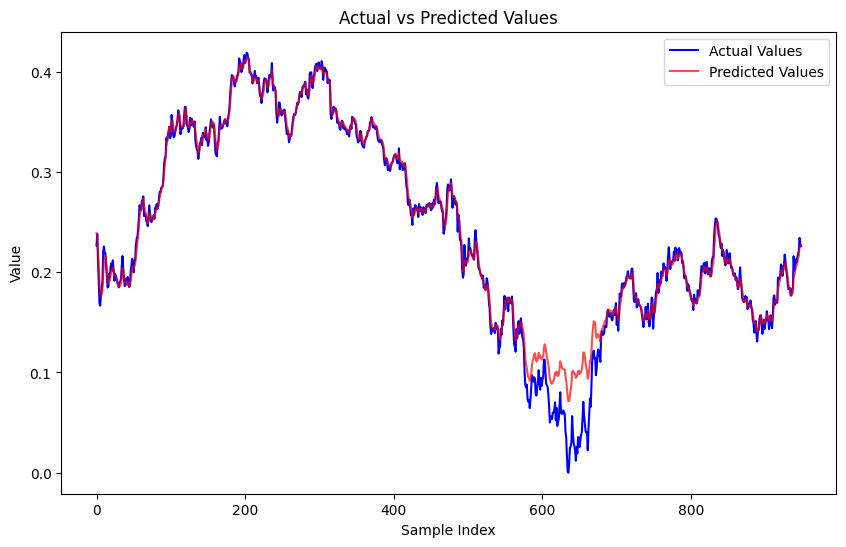

In [531]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Calculate Out-of-Sample (OOS) R^2
def oos_r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

oos_r2 = oos_r2_score(y_test, y_pred)
print(f'Out-of-Sample (OOS) R^2 Score: {oos_r2}')

# Plot actual vs predicted values using line plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='b')
plt.plot(range(len(y_test)), y_pred, label='Predicted Values', color='r', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

ValueError: x and y must be the same size

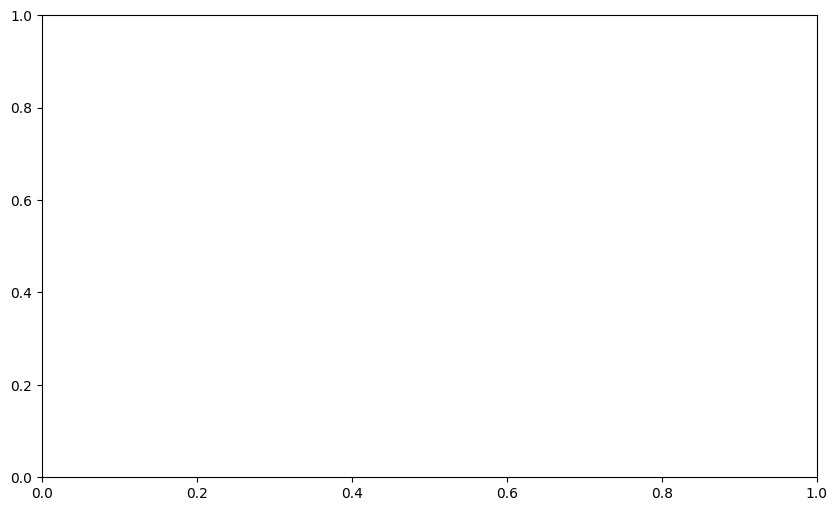

In [477]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=len(residuals), linestyles='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x700 with 0 Axes>

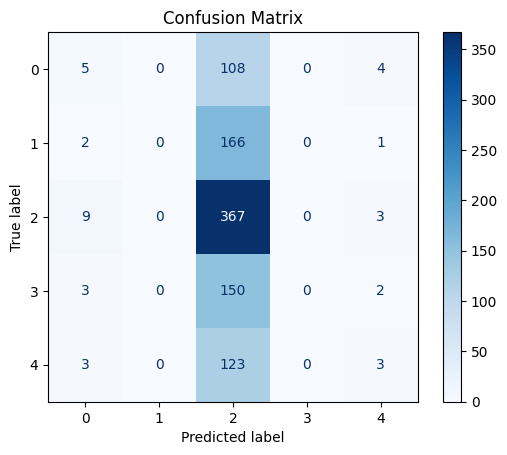

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Since best_model_5 is likely a Keras model wrapped in a Scikit-learn classifier,
# we need to convert predictions from probability distributions to class labels.
predicted_categories = np.argmax(y_pred, axis=1)

# Ensure that actual_categories has the correct length
actual_categories = y_test

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
best_model_5.summary()

In [ ]:
model_save_path = 'fifth_iteration_lstm.keras'
best_model_5.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


# Testing one hot encoding

{0: 1554, 1: 1603, 2: 1601}
Shape of X_train: (3804, 3, 28)
Shape of y_train_one_hot: (3804, 3)
Shape of X_test: (951, 3, 28)
Shape of y_test_one_hot: (951, 3)
Training set label distribution: {0: 1266, 1: 1233, 2: 1305}
Test set label distribution: {0: 286, 1: 369, 2: 296}
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3434 - loss: 1.1058 - val_accuracy: 0.3113 - val_loss: 1.0996
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3512 - loss: 1.0982 - val_accuracy: 0.3091 - val_loss: 1.1000
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3461 - loss: 1.0984 - val_accuracy: 0.3102 - val_loss: 1.0984
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3626 - loss: 1.0922 - val_accuracy: 0.3281 - val_loss: 1.0978
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3623 - loss: 1.0889 - val_accuracy: 0.3828 - val_loss: 1.0962
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3762 - loss: 1.0875

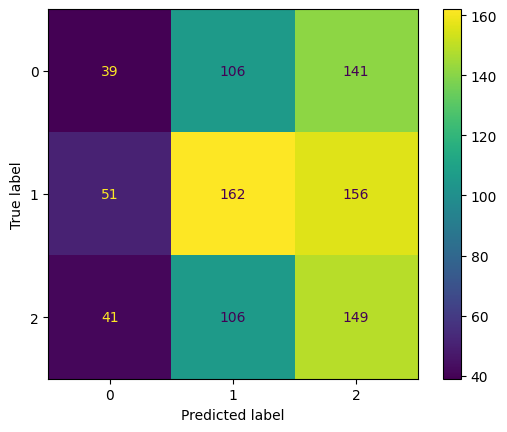

In [602]:
import numpy as np
import pandas as pd
import logging
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
logging.info('Loading dataset...')
file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64')  # Assuming the first column is not needed

# Calculate diff
diff = dataset[:, :1]

def categorize_diff(diff):
    if diff < -0.0023999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the categorization
y_categories = np.array([categorize_diff(pc) for pc in diff.flatten()])

# Verify the distribution of categories
unique, counts = np.unique(y_categories, return_counts=True)
print(dict(zip(unique, counts)))

# Normalize dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Prepare the dataset for LSTM
time_steps = 3

def create_dataset(data, labels, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_dataset(dataset_scaled, y_categories, time_steps)

# Split into train and test sets ensuring no data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Verify the shape of the dataset and the one-hot encoded labels
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train_one_hot: {y_train_one_hot.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test_one_hot: {y_test_one_hot.shape}')

# Check the label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training set label distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test set label distribution:", dict(zip(unique, counts)))

# Define the LSTM model for multi-class classification
def create_model(units1=64, units2=32,dropout_rate1=0.5, learning_rate=0.01, batch_size = 128):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units1, activation='relu'),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')  # Softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(units1=64, units2=32, dropout_rate1=0.5, learning_rate=0.01, batch_size = 128)
history = model.fit(X_train, y_train_one_hot, epochs=50, validation_data=(X_test, y_test_one_hot), verbose=1)

# Evaluate the model
results = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Generate predictions and confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 800x600 with 0 Axes>

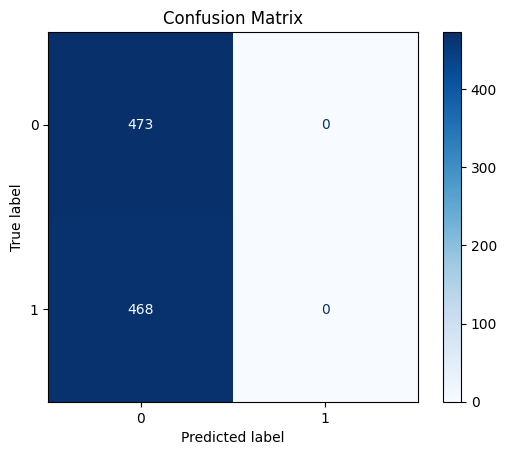

In [564]:
# Predict the classes for the test set
y_pred_prob = model_5.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded test labels back to single dimension
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Display the confusion matrix
plt.figure(figsize=(8, 6))
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()